In [800]:
import pandas as pd
from nltk.corpus import stopwords
from matplotlib import pyplot as plt
import requests
from bs4 import BeautifulSoup as bs4
import numpy as np

# ETL Hechos

In [801]:
#abrimos el archivo de excel
homicidios=pd.read_excel('Datasets\homicidios.xlsx',sheet_name=None)

In [802]:
#observamos que hojas tiene para saber cuales necestiamos
homicidios.keys()

dict_keys(['HECHOS', 'DICCIONARIO_HECHOS', 'VICTIMAS', 'DICCIONARIO_VICTIMAS', 'clas'])

In [803]:
# se pasa a un dataframe a parte la hoja de hechos
dfhechos=homicidios['HECHOS']
dfhechos.head()

,ID,N_VICTIMAS,FECHA,AAAA,MM,DD,HORA,HH,LUGAR_DEL_HECHO,TIPO_DE_CALLE,...,Altura,Cruce,Dirección Normalizada,COMUNA,XY (CABA),pos x,pos y,PARTICIPANTES,VICTIMA,ACUSADO
0,2016-0001,1,2016-01-01,2016,1,1,04:00:00,4,AV PIEDRA BUENA Y AV FERNANDEZ DE LA CRUZ,AVENIDA,...,NaN,"FERNANDEZ DE LA CRUZ, F., GRAL. AV.","PIEDRA BUENA AV. y FERNANDEZ DE LA CRUZ, F., G...",8,Point (98896.78238426 93532.43437792),-58.47533969,-34.68757022,MOTO-AUTO,MOTO,AUTO
1,2016-0002,1,2016-01-02,2016,1,2,01:15:00,1,AV GRAL PAZ Y AV DE LOS CORRALES,GRAL PAZ,...,NaN,DE LOS CORRALES AV.,"PAZ, GRAL. AV. y DE LOS CORRALES AV.",9,Point (95832.05571093 95505.41641999),-58.50877521,-34.66977709,AUTO-PASAJEROS,AUTO,PASAJEROS
2,2016-0003,1,2016-01-03,2016,1,3,07:00:00,7,AV ENTRE RIOS 2034,AVENIDA,...,2034.0,NaN,ENTRE RIOS AV. 2034,1,Point (106684.29090040 99706.57687843),-58.39040293,-34.63189362,MOTO-AUTO,MOTO,AUTO
3,2016-0004,1,2016-01-10,2016,1,10,00:00:00,0,AV LARRAZABAL Y GRAL VILLEGAS CONRADO,AVENIDA,...,NaN,"VILLEGAS, CONRADO, GRAL.","LARRAZABAL AV. y VILLEGAS, CONRADO, GRAL.",8,Point (99840.65224780 94269.16534422),-58.46503904,-34.68092974,MOTO-SD,MOTO,SD
4,2016-0005,1,2016-01-21,2016,1,21,05:20:00,5,AV SAN JUAN Y PRESIDENTE LUIS SAENZ PEÑA,AVENIDA,...,NaN,"SAENZ PE?A, LUIS, PRES.","SAN JUAN AV. y SAENZ PEÃ‘A, LUIS, PRES.",1,Point (106980.32827929 100752.16915795),-58.38718297,-34.62246630,MOTO-PASAJEROS,MOTO,PASAJEROS


In [804]:
dfhechos.columns

Index(['ID', 'N_VICTIMAS', 'FECHA', 'AAAA', 'MM', 'DD', 'HORA', 'HH',
       'LUGAR_DEL_HECHO', 'TIPO_DE_CALLE', 'Calle', 'Altura', 'Cruce',
       'Dirección Normalizada', 'COMUNA', 'XY (CABA)', 'pos x', 'pos y',
       'PARTICIPANTES', 'VICTIMA', 'ACUSADO'],
      dtype='object')

In [805]:
#revisamos todas las columnas para decidir si eliminamos algunas, o trabajmos con todas
dfhechos.drop(columns=['AAAA','MM','DD','HORA','Dirección Normalizada','XY (CABA)','PARTICIPANTES'],inplace=True)

In [806]:
dfhechos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 696 entries, 0 to 695
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   ID               696 non-null    object        
 1   N_VICTIMAS       696 non-null    int64         
 2   FECHA            696 non-null    datetime64[ns]
 3   HH               696 non-null    object        
 4   LUGAR_DEL_HECHO  696 non-null    object        
 5   TIPO_DE_CALLE    696 non-null    object        
 6   Calle            695 non-null    object        
 7   Altura           129 non-null    float64       
 8   Cruce            525 non-null    object        
 9   COMUNA           696 non-null    int64         
 10  pos x            696 non-null    object        
 11  pos y            696 non-null    object        
 12  VICTIMA          696 non-null    object        
 13  ACUSADO          696 non-null    object        
dtypes: datetime64[ns](1), float64(1), int64(2)

In [807]:
#comenzamos checando los nulos y duplicados
print(dfhechos.duplicated().sum())
print(dfhechos.isnull().sum())

0
ID                   0
N_VICTIMAS           0
FECHA                0
HH                   0
LUGAR_DEL_HECHO      0
TIPO_DE_CALLE        0
Calle                1
Altura             567
Cruce              171
COMUNA               0
pos x                0
pos y                0
VICTIMA              0
ACUSADO              0
dtype: int64


In [808]:
# al abrir los primeros datos, observaos que donde falta la aaltura, en muchas fias falta el cruce,
# y que la suma de las dos faltantes es mayor al total de filas
print(f'Nulos en Altura: {dfhechos.Altura.isnull().sum()}       {dfhechos.Altura.isnull().sum()/len(dfhechos)*100} % de total\nNulos en Cruce: {dfhechos.Cruce.isnull().sum()}        {dfhechos.Cruce.isnull().sum()/len(dfhechos)*100} % de total\nSuma de los dos faltantes:  {dfhechos.Altura.isnull().sum()+dfhechos.Cruce.isnull().sum()}\nTotal de filas: {len(dfhechos)}                        \nDiferencia entre total de filas y total de faltantes de las columnas Altura y Cruce: {-len(dfhechos)+dfhechos.Altura.isnull().sum()+dfhechos.Cruce.isnull().sum()}')

Nulos en Altura: 567       81.46551724137932 % de total
Nulos en Cruce: 171        24.568965517241377 % de total
Suma de los dos faltantes:  738
Total de filas: 696                        
Diferencia entre total de filas y total de faltantes de las columnas Altura y Cruce: 42


In [809]:
dfhechos[['Altura','Cruce']][dfhechos.Altura.isnull()].head()

,Altura,Cruce
0,NaN,"FERNANDEZ DE LA CRUZ, F., GRAL. AV."
1,NaN,DE LOS CORRALES AV.
3,NaN,"VILLEGAS, CONRADO, GRAL."
4,NaN,"SAENZ PE?A, LUIS, PRES."
5,NaN,ESCALADA AV.


In [810]:
dfhechos[['Altura','Cruce']][dfhechos.Cruce.isnull()].head()

,Altura,Cruce
2,2034.0,NaN
9,1366.0,NaN
14,156.0,NaN
33,1483.0,NaN
35,NaN,NaN


In [811]:
ambosnulo=len(dfhechos[['Altura','Cruce']][(dfhechos.Cruce.isnull())&dfhechos.Altura.isnull()])
print('Filas donde la calle es nula y el cruce es nulo= ',ambosnulo)
dfhechos[(dfhechos.Cruce.isnull())&dfhechos.Altura.isnull()].head()

Filas donde la calle es nula y el cruce es nulo=  42


,ID,N_VICTIMAS,FECHA,HH,LUGAR_DEL_HECHO,TIPO_DE_CALLE,Calle,Altura,Cruce,COMUNA,pos x,pos y,VICTIMA,ACUSADO
35,2016-0049,1,2016-04-17,0,AUTOPISTA 1 SUR PRESIDENTE ARTURO FRONDIZI KM....,AUTOPISTA,AUTOPISTA 1 SUR PRESIDENTE ARTURO FRONDIZI,NaN,NaN,4,-58.37714647568196,-34.63657525428238,SD,SD
38,2016-0052,1,2016-04-20,20,AUTOPISTA LUGONES PK 10000,AUTOPISTA,"LUGONES, LEOPOLDO AV.",NaN,NaN,13,.,.,MOTO,SD
64,2016-0087,1,2016-07-02,0,AUTOPISTA 1 SUR PTE ARTURO FRONDIZI Y AV CASEROS,AUTOPISTA,AUTOPISTA 1 SUR PRESIDENTE ARTURO FRONDIZI,NaN,NaN,1,-58.37864583,-34.62907067,MOTO,OBJETO FIJO
71,2016-0096,1,2016-07-25,7,"AUTOPISTA DELLEPIANE LUIS TTE. GRAL. KM. 2,3",AUTOPISTA,AUTOPISTA DELLEPIANE LUIS TTE. GRAL.,NaN,NaN,8,-58.47433193007387,-34.66684950051973,MOTO,CARGAS
81,2016-0107,1,2016-08-20,8,AUTOPISTA 9 DE JULIO SUR ALT AV MENDOZA,AUTOPISTA,AUTOPISTA 1 SUR PRESIDENTE ARTURO FRONDIZI,NaN,NaN,4,-58.37157668,-34.65429986,MOTO,AUTO


Aqui podemos observar que cuando falta un dato en cruce, se presenta en altura, esto es porque no siempre se dan los accidnetes viales en la esquinas, y hay pocos datos donde em ambos son nulos que son el 5% del toal del dataframe, dado que la columna de cruce y altura, nos indican solamente en donde es mas probable un accidente, no se pueden retirar del dataframe.

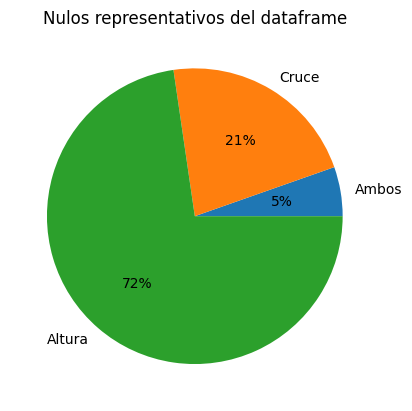

In [812]:
plt.pie(x=[ambosnulo,dfhechos.Cruce.isnull().sum(),dfhechos.Altura.isnull().sum()],labels=['Ambos','Cruce','Altura'],autopct='%d%%')
plt.title('Nulos representativos del dataframe')
plt.show()

In [813]:
#ccreamos una columna nueva, donde solo nos indique si el choque ocurrió en un cruce de calles o entre dos esquinas
# si no existe ninguno de los dos datos, se pone SD siguiendo el mismo patrón que tiene el dataset
dfhechos.loc[dfhechos.Altura.notnull(),'Cruce_o_Altura']='Altura'
dfhechos.loc[dfhechos.Cruce.notnull(),'Cruce_o_Altura']='Cruce'
dfhechos.Cruce_o_Altura.fillna('SD',inplace=True)
dfhechos.drop(columns=['Cruce','Altura'],inplace=True)
print('nulos restantes: ',dfhechos.isnull().sum())
dfhechos.head()

nulos restantes:  ID                 0
N_VICTIMAS         0
FECHA              0
HH                 0
LUGAR_DEL_HECHO    0
TIPO_DE_CALLE      0
Calle              1
COMUNA             0
pos x              0
pos y              0
VICTIMA            0
ACUSADO            0
Cruce_o_Altura     0
dtype: int64


,ID,N_VICTIMAS,FECHA,HH,LUGAR_DEL_HECHO,TIPO_DE_CALLE,Calle,COMUNA,pos x,pos y,VICTIMA,ACUSADO,Cruce_o_Altura
0,2016-0001,1,2016-01-01,4,AV PIEDRA BUENA Y AV FERNANDEZ DE LA CRUZ,AVENIDA,PIEDRA BUENA AV.,8,-58.47533969,-34.68757022,MOTO,AUTO,Cruce
1,2016-0002,1,2016-01-02,1,AV GRAL PAZ Y AV DE LOS CORRALES,GRAL PAZ,"PAZ, GRAL. AV.",9,-58.50877521,-34.66977709,AUTO,PASAJEROS,Cruce
2,2016-0003,1,2016-01-03,7,AV ENTRE RIOS 2034,AVENIDA,ENTRE RIOS AV.,1,-58.39040293,-34.63189362,MOTO,AUTO,Altura
3,2016-0004,1,2016-01-10,0,AV LARRAZABAL Y GRAL VILLEGAS CONRADO,AVENIDA,LARRAZABAL AV.,8,-58.46503904,-34.68092974,MOTO,SD,Cruce
4,2016-0005,1,2016-01-21,5,AV SAN JUAN Y PRESIDENTE LUIS SAENZ PEÑA,AVENIDA,SAN JUAN AV.,1,-58.38718297,-34.62246630,MOTO,PASAJEROS,Cruce


In [814]:
#observamos que esa fila con un nulo en calle no contiene datos relevantes, y el porcentaje que representa es muy bajo, por lo que se decide borrar
print(dfhechos[dfhechos.Calle.isnull()])
print(f'porcentaje que representa el nulo en Calle: {dfhechos.Calle.isnull().sum()/len(dfhechos)*100} %')
print('porcentaje sobre el total de accidentes del mismo año donde la calle es nulo: ',dfhechos.Calle.isnull().sum()/(dfhechos.FECHA.dt.year==dfhechos.FECHA[dfhechos.Calle.isnull()].dt.year.iloc[0]).sum()*100,'%')
dfhechos.dropna(subset='Calle',inplace=True)

            ID  N_VICTIMAS      FECHA  HH LUGAR_DEL_HECHO TIPO_DE_CALLE Calle  \
119  2016-0151           1 2016-11-18  20              SD         CALLE   NaN   

     COMUNA pos x pos y VICTIMA ACUSADO Cruce_o_Altura  
119       0     .     .  PEATON      SD             SD  
porcentaje que representa el nulo en Calle: 0.14367816091954022 %
porcentaje sobre el total de accidentes del mismo año donde la calle es nulo:  0.6944444444444444 %


In [815]:
#procedemos a checar que ya no existan nulos
dfhechos.isnull().sum().sum()

0

In [816]:
dfhechos['HH']=dfhechos.HH.astype(str)
dfhechos['pos x']=dfhechos['pos x'].astype(str)
dfhechos['pos y']=dfhechos['pos y'].astype(str)

In [817]:
#quitamos las columnas de lugar del hecho, ya que  para fines de analsis no nos son relevantes, al ser muchos datos distintos, no nos arrojan un dato relevante
print('lugar del hecho únicos: ',len(dfhechos.LUGAR_DEL_HECHO.unique()))
dfhechos.drop(columns='LUGAR_DEL_HECHO',inplace=True)
dfhechos.head()

lugar del hecho únicos:  682


,ID,N_VICTIMAS,FECHA,HH,TIPO_DE_CALLE,Calle,COMUNA,pos x,pos y,VICTIMA,ACUSADO,Cruce_o_Altura
0,2016-0001,1,2016-01-01,4,AVENIDA,PIEDRA BUENA AV.,8,-58.47533969,-34.68757022,MOTO,AUTO,Cruce
1,2016-0002,1,2016-01-02,1,GRAL PAZ,"PAZ, GRAL. AV.",9,-58.50877521,-34.66977709,AUTO,PASAJEROS,Cruce
2,2016-0003,1,2016-01-03,7,AVENIDA,ENTRE RIOS AV.,1,-58.39040293,-34.63189362,MOTO,AUTO,Altura
3,2016-0004,1,2016-01-10,0,AVENIDA,LARRAZABAL AV.,8,-58.46503904,-34.68092974,MOTO,SD,Cruce
4,2016-0005,1,2016-01-21,5,AVENIDA,SAN JUAN AV.,1,-58.38718297,-34.62246630,MOTO,PASAJEROS,Cruce


In [818]:
#cambiamos el formato de los datos, de mayusculas, a tener cada palabra la primer letra mayúscula
cols=dfhechos.select_dtypes(include='object').columns
stop_words=list(stopwords.words('spanish'))
for b in cols:
    dfhechos[b]=dfhechos[b].apply(lambda x: ' '.join([a.capitalize() if a.lower() not in stop_words else a.lower() for a in x.split(' ')]))



In [819]:
dfhechos.head()

,ID,N_VICTIMAS,FECHA,HH,TIPO_DE_CALLE,Calle,COMUNA,pos x,pos y,VICTIMA,ACUSADO,Cruce_o_Altura
0,2016-0001,1,2016-01-01,4,Avenida,Piedra Buena Av.,8,-58.47533969,-34.68757022,Moto,Auto,Cruce
1,2016-0002,1,2016-01-02,1,Gral Paz,"Paz, Gral. Av.",9,-58.50877521,-34.66977709,Auto,Pasajeros,Cruce
2,2016-0003,1,2016-01-03,7,Avenida,entre Rios Av.,1,-58.39040293,-34.63189362,Moto,Auto,Altura
3,2016-0004,1,2016-01-10,0,Avenida,Larrazabal Av.,8,-58.46503904,-34.68092974,Moto,Sd,Cruce
4,2016-0005,1,2016-01-21,5,Avenida,San Juan Av.,1,-58.38718297,-34.62246630,Moto,Pasajeros,Cruce


In [820]:
#observamos que hay filas donde no hay valor de coordenadas
print(dfhechos.COMUNA[(dfhechos['pos x'].str.len()<3)|(dfhechos['pos y'].str.len()<3)].count())

11


In [821]:
#sacamos de internet las coordenadas de las direcciones donde el dato no existe, el eje x y y estaban vacíos
#así nos pueden servir mas adelante para un mapa de calor, se les asigna las coordenadas de la comuna, para fines de geolocalización por comuna
#al no necesitar ubicación exacta
for a in dfhechos.COMUNA[(dfhechos['pos x'].str.len()<3)|(dfhechos['pos y'].str.len()<3)].unique():
    response=requests.get('https://es.wikipedia.org/wiki/Comuna_'+str(a)+'_(Ciudad_de_Buenos_Aires)')
    soup=bs4(response.text,'html.parser')
    try:
        long=str(soup.find('span',class_='longitude').text)
        lat=str(soup.find('span',class_='latitude').text)
    except:
        print('comuna con error: ',a)
        continue
    lat=lat.strip(' ')
    long=long.strip(' ')
    lat=lat.replace('°',',')
    lat=lat.replace('′',',')
    lat=lat.replace('″',',')
    long=long.replace('°',',')
    long=long.replace('′',',')
    long=long.replace('″',',')
    lat=lat.split(',')
    long=long.split(',')
    la=0
    if lat[-1] in ['O','S']:
        lat=(float(lat[0])+(float(lat[1])/60)+(float(lat[2])/3600))*-1
    if long[-1] in ['O','S']:
        long=(float(long[0])+(float(long[1])/60)+(float(long[2])/3600))*-1
    dfhechos.loc[(dfhechos['pos x'].str.len()<3)&(dfhechos.COMUNA==a),'pos x']=str(long)
    dfhechos.loc[(dfhechos['pos y'].str.len()<3)&(dfhechos.COMUNA==a),'pos y']=str(lat)
#Verificammos cuantas comunas dieron error
print(dfhechos.COMUNA[(dfhechos['pos x'].str.len()<3)|(dfhechos['pos y'].str.len()<3)].count())
#Al solo ser un dato del total de nuestros datos, no tendra mayor relevacia al hacer un mapa de calor

comuna con error:  0
1


In [822]:
dfhechos.head()

,ID,N_VICTIMAS,FECHA,HH,TIPO_DE_CALLE,Calle,COMUNA,pos x,pos y,VICTIMA,ACUSADO,Cruce_o_Altura
0,2016-0001,1,2016-01-01,4,Avenida,Piedra Buena Av.,8,-58.47533969,-34.68757022,Moto,Auto,Cruce
1,2016-0002,1,2016-01-02,1,Gral Paz,"Paz, Gral. Av.",9,-58.50877521,-34.66977709,Auto,Pasajeros,Cruce
2,2016-0003,1,2016-01-03,7,Avenida,entre Rios Av.,1,-58.39040293,-34.63189362,Moto,Auto,Altura
3,2016-0004,1,2016-01-10,0,Avenida,Larrazabal Av.,8,-58.46503904,-34.68092974,Moto,Sd,Cruce
4,2016-0005,1,2016-01-21,5,Avenida,San Juan Av.,1,-58.38718297,-34.62246630,Moto,Pasajeros,Cruce


In [823]:
# checamos las columnas comuna, vcitima y acusado para bsucar datos unicos, atipicos, y vemos que en com,una hay uno que dice comuna 0
print(dfhechos.COMUNA.unique())
print(dfhechos.VICTIMA.unique())
print(dfhechos.ACUSADO.unique())

[ 8  9  1 11 15  4  7 12  3 13 14 10  6  2  5  0]
['Moto' 'Auto' 'Peaton' 'Sd' 'Cargas' 'Bicicleta' 'Pasajeros' 'Movil'
 'Objeto Fijo' 'Peaton_moto']
['Auto' 'Pasajeros' 'Sd' 'Objeto Fijo' 'Cargas' 'Moto' 'Multiple' 'otro'
 'Bicicleta' 'Tren']


In [824]:
#cheCAR ESTE DATO MAÑANA
dfhechos[dfhechos.COMUNA==0]

,ID,N_VICTIMAS,FECHA,HH,TIPO_DE_CALLE,Calle,COMUNA,pos x,pos y,VICTIMA,ACUSADO,Cruce_o_Altura
139,2016-0174,1,2016-12-27,0,Autopista,Autopista 25 de Mayo,0,.,.,Sd,Sd,Sd


In [825]:
#ahora vamos a cambiar primero los nombres de las columnas a modo que tengas la primer letra mayúscula
columnas=dfhechos.columns
cols={}
for a in dfhechos.columns:
    cols[a]=a.capitalize()
dfhechos.rename(columns=cols,inplace=True)
dfhechos.rename(columns={'N_victimas':'No_víctimas','Victima':'Víctimas','Hh':'Hora'},inplace=True)
dfhechos.columns

Index(['Id', 'No_víctimas', 'Fecha', 'Hora', 'Tipo_de_calle', 'Calle',
       'Comuna', 'Pos x', 'Pos y', 'Víctimas', 'Acusado', 'Cruce_o_altura'],
      dtype='object')

In [866]:
dfhechos.to_csv('Datasets/homicidios_hechos.csv',index=False)

# ETL Víctimas

In [826]:
dfvictimas=homicidios['VICTIMAS']
dfvictimas.head()

,ID_hecho,FECHA,AAAA,MM,DD,ROL,VICTIMA,SEXO,EDAD,FECHA_FALLECIMIENTO
0,2016-0001,2016-01-01,2016,1,1,CONDUCTOR,MOTO,MASCULINO,19,2016-01-01 00:00:00
1,2016-0002,2016-01-02,2016,1,2,CONDUCTOR,AUTO,MASCULINO,70,2016-01-02 00:00:00
2,2016-0003,2016-01-03,2016,1,3,CONDUCTOR,MOTO,MASCULINO,30,2016-01-03 00:00:00
3,2016-0004,2016-01-10,2016,1,10,CONDUCTOR,MOTO,MASCULINO,18,SD
4,2016-0005,2016-01-21,2016,1,21,CONDUCTOR,MOTO,MASCULINO,29,2016-02-01 00:00:00


In [827]:
dfvictimas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 717 entries, 0 to 716
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ID_hecho             717 non-null    object        
 1   FECHA                717 non-null    datetime64[ns]
 2   AAAA                 717 non-null    int64         
 3   MM                   717 non-null    int64         
 4   DD                   717 non-null    int64         
 5   ROL                  717 non-null    object        
 6   VICTIMA              717 non-null    object        
 7   SEXO                 717 non-null    object        
 8   EDAD                 717 non-null    object        
 9   FECHA_FALLECIMIENTO  717 non-null    object        
dtypes: datetime64[ns](1), int64(3), object(6)
memory usage: 56.1+ KB


In [828]:
#primero checaremos si hay nulos o duplicados
print('Nulos: ',dfvictimas.isnull().sum().sum())
print('Duplicados: ',dfvictimas.duplicated().sum())


Nulos:  0
Duplicados:  0


In [829]:
cols=['ROL','VICTIMA','SEXO']
stop_words=list(stopwords.words('spanish'))
for b in cols:
    dfvictimas[b]=dfvictimas[b].apply(lambda x: ' '.join([a.capitalize() if a.lower() not in stop_words else a.lower() for a in x.split(' ')]))
dfvictimas.head()

,ID_hecho,FECHA,AAAA,MM,DD,ROL,VICTIMA,SEXO,EDAD,FECHA_FALLECIMIENTO
0,2016-0001,2016-01-01,2016,1,1,Conductor,Moto,Masculino,19,2016-01-01 00:00:00
1,2016-0002,2016-01-02,2016,1,2,Conductor,Auto,Masculino,70,2016-01-02 00:00:00
2,2016-0003,2016-01-03,2016,1,3,Conductor,Moto,Masculino,30,2016-01-03 00:00:00
3,2016-0004,2016-01-10,2016,1,10,Conductor,Moto,Masculino,18,SD
4,2016-0005,2016-01-21,2016,1,21,Conductor,Moto,Masculino,29,2016-02-01 00:00:00


In [830]:
#quitamos las columnas que no necesitamos
dfvictimas.drop(columns=['AAAA','MM','DD'],inplace=True)

In [831]:
dfvictimas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 717 entries, 0 to 716
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ID_hecho             717 non-null    object        
 1   FECHA                717 non-null    datetime64[ns]
 2   ROL                  717 non-null    object        
 3   VICTIMA              717 non-null    object        
 4   SEXO                 717 non-null    object        
 5   EDAD                 717 non-null    object        
 6   FECHA_FALLECIMIENTO  717 non-null    object        
dtypes: datetime64[ns](1), object(6)
memory usage: 39.3+ KB


In [832]:
df1=pd.to_datetime(dfvictimas.loc[dfvictimas['FECHA_FALLECIMIENTO']!='SD','FECHA_FALLECIMIENTO'])-pd.to_datetime(dfvictimas.loc[dfvictimas['FECHA_FALLECIMIENTO']!='SD','FECHA'])
dfvictimas.loc[dfvictimas['FECHA_FALLECIMIENTO']!='SD','Días_de_muerte_post_accidente']=df1.dt.days
dfvictimas.loc[dfvictimas['Días_de_muerte_post_accidente'].notnull(),'Días_de_muerte_post_accidente']=dfvictimas.loc[dfvictimas['Días_de_muerte_post_accidente'].notnull(),'Días_de_muerte_post_accidente'].astype(int)
dfvictimas['Días_de_muerte_post_accidente'].fillna('SD',inplace=True)
dfvictimas.drop(columns='FECHA_FALLECIMIENTO',inplace=True)
dfvictimas.head()

,ID_hecho,FECHA,ROL,VICTIMA,SEXO,EDAD,Días_de_muerte_post_accidente
0,2016-0001,2016-01-01,Conductor,Moto,Masculino,19,0.0
1,2016-0002,2016-01-02,Conductor,Auto,Masculino,70,0.0
2,2016-0003,2016-01-03,Conductor,Moto,Masculino,30,0.0
3,2016-0004,2016-01-10,Conductor,Moto,Masculino,18,SD
4,2016-0005,2016-01-21,Conductor,Moto,Masculino,29,11.0


In [833]:
#ahora vamos a cambiar primero los nombres de las columnas a modo que tengas la primer letra mayúscula
cols={}
for a in dfvictimas.columns:
    cols[a]=a.capitalize()
dfvictimas.rename(columns=cols,inplace=True)
dfvictimas.rename({'Victima':'Víctima'},inplace=True)
dfvictimas.columns

Index(['Id_hecho', 'Fecha', 'Rol', 'Victima', 'Sexo', 'Edad',
       'Días_de_muerte_post_accidente'],
      dtype='object')

In [867]:
dfvictimas.to_csv('Datasets/homicidios_victimas.csv',index=False)

# ETL Lesiones

In [834]:
lesiones=pd.read_excel('Datasets\lesiones.xlsx',sheet_name=None)
dfhechos2=lesiones['HECHOS']

In [835]:
#observamos que no hay filas duplicadas en hechos
dfhechos2.duplicated().sum()

0

In [836]:
#checamos si existen datos nulos, y en caso de haberlos, primero se decidirá con que columnas se van a trabajar, para después elegir el tratamiento de los datos nulos
dfhechos2.isnull().sum()

id                           0
n_victimas                   0
aaaa                         0
mm                           0
dd                           0
fecha                        0
hora                         0
franja_hora                  5
direccion_normalizada       53
comuna                     169
tipo_calle                   0
otra_direccion               0
calle                    10918
altura                   11014
cruce                    14378
geocodificacion_CABA        39
longitud                   262
latutid                    262
victima                      0
acusado                      0
participantes                0
moto                        93
auto                        93
transporte_publico          93
camion                      93
ciclista                    93
gravedad                     0
dtype: int64

In [837]:
dfhechos2.head()

,id,n_victimas,aaaa,mm,dd,fecha,hora,franja_hora,direccion_normalizada,comuna,...,latutid,victima,acusado,participantes,moto,auto,transporte_publico,camion,ciclista,gravedad
0,LC-2019-0000179,1,2019,1,1,2019-01-01 00:00:00,09:00:00,9,SD,14,...,-34.559658,CICLISTA,SD,CICLISTA-SD,SD,SD,SD,SD,x,SD
1,LC-2019-0000053,1,2019,1,1,2019-01-01 00:00:00,01:55:00,1,SD,8,...,-34.669125,AUTO,SD,AUTO-SD,SD,x,SD,SD,SD,SD
2,LC-2019-0000063,1,2019,1,1,2019-01-01 00:00:00,02:00:00,2,SD,8,...,-34.677556,SD,SD,SD-SD,SD,SD,SD,SD,SD,SD
3,LC-2019-0000079,1,2019,1,1,2019-01-01 00:00:00,02:30:00,2,SD,7,...,-34.647349,PEATON,SD,PEATON-SD,x,SD,SD,SD,SD,SD
4,LC-2019-0000082,4,2019,1,1,2019-01-01 00:00:00,04:30:00,4,SD,3,...,-34.604579,AUTO,SD,AUTO-SD,SD,SD,x,SD,SD,SD


In [838]:
dfhechos2.columns

Index(['id', 'n_victimas', 'aaaa', 'mm', 'dd', 'fecha', 'hora', 'franja_hora',
       'direccion_normalizada', 'comuna', 'tipo_calle', 'otra_direccion',
       'calle', 'altura', 'cruce', 'geocodificacion_CABA', 'longitud',
       'latutid', 'victima', 'acusado', 'participantes', 'moto', 'auto',
       'transporte_publico', 'camion', 'ciclista', 'gravedad'],
      dtype='object')

In [839]:
#no hay ids duplicaods, por lo que estos datos a grandes razgos no presentan errores
dfhechos2.id.duplicated().sum()


0

In [840]:
#quitamos la columna de franja_hora, ya que la columna hora contiene el dato completo de la hora
dfhechos2.drop(columns=['franja_hora','aaaa','mm','dd','direccion_normalizada','participantes'],inplace=True)
dfhechos2.head()

,id,n_victimas,fecha,hora,comuna,tipo_calle,otra_direccion,calle,altura,cruce,...,longitud,latutid,victima,acusado,moto,auto,transporte_publico,camion,ciclista,gravedad
0,LC-2019-0000179,1,2019-01-01 00:00:00,09:00:00,14,SD,"Obligado Rafael, Av.Costanera 3300, Barrio: Pa...",NaN,NaN,NaN,...,-58.408911,-34.559658,CICLISTA,SD,SD,SD,SD,SD,x,SD
1,LC-2019-0000053,1,2019-01-01 00:00:00,01:55:00,8,SD,"Autopista Presidente Héctor J. Cámpora y Roca,...",NaN,NaN,NaN,...,-58.44351,-34.669125,AUTO,SD,SD,x,SD,SD,SD,SD
2,LC-2019-0000063,1,2019-01-01 00:00:00,02:00:00,8,SD,"Barros Pazos, Jose y Larraya 0, Barrio: Villa ...",NaN,NaN,NaN,...,-58.468335,-34.677556,SD,SD,SD,SD,SD,SD,SD,SD
3,LC-2019-0000079,1,2019-01-01 00:00:00,02:30:00,7,SD,"Torres Y Tenorio, Pres. y Riestra Av. 0, Barri...",NaN,NaN,NaN,...,-58.437425,-34.647349,PEATON,SD,x,SD,SD,SD,SD,SD
4,LC-2019-0000082,4,2019-01-01 00:00:00,04:30:00,3,SD,"Corrientes Av. y Uriburu Jose E., Pres. 0, Bar...",NaN,NaN,NaN,...,-58.398225,-34.604579,AUTO,SD,SD,SD,x,SD,SD,SD


In [841]:
#observamos que hay valores en n_vcitimas, algunos con 0 y otros mayor a 1 victima
print(dfhechos2.n_victimas.sort_values().unique())
print(dfhechos2[dfhechos2.n_victimas==0])
#se quita esa fila donde el no. de víctimas es 0, ya que nuestro análisis es enfocado a accidentes viales con víctimas, y en este caso, la mayoría de columnas no tienen datos, 
dfhechos2.drop(index=dfhechos2[dfhechos2.n_victimas==0].index,inplace=True)

[ 0  1  2  3  4  5  6  7  8 10 16]
                    id  n_victimas                fecha hora comuna  \
9928  PNA-2019-0005246           0  2019-12-20 00:00:00   SD    NaN   

     tipo_calle otra_direccion              calle  altura cruce  ... longitud  \
9928         SD             SD  27 DE FEBRERO AV.  6300.0   NaN  ...      NaN   

     latutid victima acusado moto auto transporte_publico camion ciclista  \
9928     NaN      SD      SD   SD   SD                 SD     SD       SD   

     gravedad  
9928       SD  

[1 rows x 21 columns]


In [842]:
#hacemos una columna donde nos indidque, si el incidente ocurrió en cruce, altura o no existe el dato
dfhechos2.loc[dfhechos2.cruce.notnull(),'Cruce_o_Altura']='Cruce'
dfhechos2.loc[dfhechos2.altura.notnull(),'Cruce_o_Altura']='Altura'
dfhechos2.loc[(dfhechos2.otra_direccion=='SD')&(dfhechos2.Cruce_o_Altura.isnull()),'Cruce_o_Altura']='SD'
dfhechos2.loc[(dfhechos2.otra_direccion.str.contains('SD '))&(dfhechos2.Cruce_o_Altura.isnull()),'Cruce_o_Altura']='SD'
dfhechos2.loc[(dfhechos2.otra_direccion.str.contains(' y ',case=False))&(dfhechos2.Cruce_o_Altura.isnull()),'Cruce_o_Altura']='Cruce'
dfhechos2.loc[(dfhechos2.Cruce_o_Altura.isnull())&(dfhechos2.otra_direccion!='SD')&(dfhechos2.otra_direccion.notnull()),'Cruce_o_Altura']='Altura'
dfhechos2[dfhechos2.Cruce_o_Altura.isna()]
dfhechos2.head()

,id,n_victimas,fecha,hora,comuna,tipo_calle,otra_direccion,calle,altura,cruce,...,latutid,victima,acusado,moto,auto,transporte_publico,camion,ciclista,gravedad,Cruce_o_Altura
0,LC-2019-0000179,1,2019-01-01 00:00:00,09:00:00,14,SD,"Obligado Rafael, Av.Costanera 3300, Barrio: Pa...",NaN,NaN,NaN,...,-34.559658,CICLISTA,SD,SD,SD,SD,SD,x,SD,Altura
1,LC-2019-0000053,1,2019-01-01 00:00:00,01:55:00,8,SD,"Autopista Presidente Héctor J. Cámpora y Roca,...",NaN,NaN,NaN,...,-34.669125,AUTO,SD,SD,x,SD,SD,SD,SD,Cruce
2,LC-2019-0000063,1,2019-01-01 00:00:00,02:00:00,8,SD,"Barros Pazos, Jose y Larraya 0, Barrio: Villa ...",NaN,NaN,NaN,...,-34.677556,SD,SD,SD,SD,SD,SD,SD,SD,Cruce
3,LC-2019-0000079,1,2019-01-01 00:00:00,02:30:00,7,SD,"Torres Y Tenorio, Pres. y Riestra Av. 0, Barri...",NaN,NaN,NaN,...,-34.647349,PEATON,SD,x,SD,SD,SD,SD,SD,Cruce
4,LC-2019-0000082,4,2019-01-01 00:00:00,04:30:00,3,SD,"Corrientes Av. y Uriburu Jose E., Pres. 0, Bar...",NaN,NaN,NaN,...,-34.604579,AUTO,SD,SD,SD,x,SD,SD,SD,Cruce


In [843]:
#donde no tenemos el número de com,una, vamos a poner SD, se busco formas de encontrar que comuna son, pero no se encontro una adecuada, por lo que se dejo sin dato
print(dfhechos2.comuna.astype(str).sort_values().unique())
dfhechos2.loc[(dfhechos2.comuna.isin(['No Especificada','SD',np.NAN]))&(dfhechos2.otra_direccion=='SD')&(dfhechos2.longitud=='SD')&(dfhechos2.latutid=='SD'), 'comuna']='SD'
dfhechos2.loc[dfhechos2.comuna.isin(['No Especificada','SD',np.NAN]),'comuna']='SD'
print(dfhechos2.comuna.astype(str).sort_values().unique())

['1' '10' '11' '12' '13' '14' '15' '2' '3' '4' '5' '6' '7' '8' '9'
 'No Especificada' 'SD' 'nan']
['1' '10' '11' '12' '13' '14' '15' '2' '3' '4' '5' '6' '7' '8' '9' 'SD']


In [844]:
#ahora de los datos de otras columnas, vamos a rellenar los valores de la columna tipo_calle donde hay SD, dejando los menos valores posibles con SD, para que nuestrios analisis sean mas ceteros
print(dfhechos2.tipo_calle.unique())
dfhechos2.loc[(dfhechos2.tipo_calle=='SD')&(dfhechos2.otra_direccion.str.split(',',expand=True)[0].str.contains('av',case=False)),'tipo_calle']='AVENIDA'
dfhechos2.loc[(dfhechos2.tipo_calle=='SD')&(dfhechos2.otra_direccion.str.split(',',expand=True)[0].str.split('y',expand=True)[0].str.contains('aut',case=False)),'tipo_calle']='AUTOPISTA'
dfhechos2.loc[(dfhechos2.tipo_calle=='SD')&(dfhechos2.otra_direccion.str.split(' y ',expand=True)[0].str.contains('paz, gral',case=False)),'tipo_calle']='GRAL PAZ'
dfhechos2.loc[(dfhechos2.tipo_calle=='SD')&(dfhechos2.otra_direccion!='SD'),'tipo_calle']='CALLE'
dfhechos2.loc[(dfhechos2.otra_direccion=='SD SD'),'tipo_calle']='SD'
dfhechos2.loc[(dfhechos2.otra_direccion=='SD SD'),'otra_direccion']='SD'
dfhechos2.loc[(dfhechos2.Cruce_o_Altura=='Altura')&(dfhechos2.tipo_calle=='SD')&(dfhechos2.calle.str.contains('paz, gral',case=False)),'tipo_calle']='GRAL PAZ'
dfhechos2.loc[(dfhechos2.Cruce_o_Altura=='Cruce')&(dfhechos2.tipo_calle=='SD')&(dfhechos2.calle.str.contains('paz, gral.',case=False)),'tipo_calle']='GRAL PAZ'
dfhechos2.loc[(dfhechos2.Cruce_o_Altura=='Cruce')&(dfhechos2.tipo_calle=='SD')&(dfhechos2.calle.str.contains('av.',case=False)),'tipo_calle']='AVENIDA'
dfhechos2.loc[(dfhechos2.Cruce_o_Altura=='Altura')&(dfhechos2.tipo_calle=='SD')&(dfhechos2.calle.str.contains('av.',case=False)),'tipo_calle']='AVENIDA'
dfhechos2.loc[(dfhechos2.Cruce_o_Altura=='Cruce')&(dfhechos2.tipo_calle=='SD')&(dfhechos2.calle.str.contains('aut',case=False)),'tipo_calle']='AUTOPISTA'
dfhechos2.loc[(dfhechos2.Cruce_o_Altura=='Altura')&(dfhechos2.tipo_calle=='SD')&(dfhechos2.calle.str.contains('av.',case=False)),'tipo_calle']
dfhechos2.loc[(dfhechos2.tipo_calle=='SD')&(dfhechos2.Cruce_o_Altura!='SD')&(dfhechos2.otra_direccion.notnull()),'tipo_calle']='CALLE'
dfhechos2.loc[(dfhechos2.tipo_calle=='SD')]

['SD' 'AVENIDA' 'CALLE' 'GRAL PAZ' 'AUTOPISTA']


,id,n_victimas,fecha,hora,comuna,tipo_calle,otra_direccion,calle,altura,cruce,...,latutid,victima,acusado,moto,auto,transporte_publico,camion,ciclista,gravedad,Cruce_o_Altura
72,LC-2019-0007634,1,2019-01-04 00:00:00,14:50:00,SD,SD,SD,NaN,NaN,NaN,...,SD,MOTO,SD,x,SD,SD,SD,SD,SD,SD
93,LC-2019-0008974,1,2019-01-05 00:00:00,09:30:00,SD,SD,SD,NaN,NaN,NaN,...,SD,CICLISTA,SD,SD,SD,SD,SD,x,SD,SD
123,LC-2019-0010983,2,2019-01-06 00:00:00,22:20:00,SD,SD,SD,NaN,NaN,NaN,...,SD,AUTO,SD,SD,x,SD,SD,SD,SD,SD
128,LC-2019-0011092,1,2019-01-07 00:00:00,03:50:00,SD,SD,SD,NaN,NaN,NaN,...,SD,PEATON,SD,SD,SD,SD,SD,SD,SD,SD
186,LC-2019-0017186,1,2019-01-09 00:00:00,11:55:00,SD,SD,SD,NaN,NaN,NaN,...,SD,SD,SD,SD,SD,SD,SD,SD,SD,SD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23607,LC-2021-0638528,1,2021-12-22 00:00:00,00:00:00,SD,SD,SD,NaN,NaN,NaN,...,SD,AUTO,AUTO,0,x,0,0,0,SD,SD
23642,LC-2021-0640811,1,2021-12-23 00:00:00,18:00:00,SD,SD,SD,NaN,NaN,NaN,...,SD,SD,SD,SD,SD,SD,SD,SD,SD,SD
23669,LC-2021-0641851,1,2021-12-25 00:00:00,00:00:00,SD,SD,SD,NaN,NaN,NaN,...,SD,AUTO,SD,SD,x,SD,SD,SD,GRAVE,SD
23740,LC-2021-0649774,1,2021-12-29 00:00:00,00:00:00,SD,SD,SD,NaN,NaN,NaN,...,SD,PEATON,MOTO,x,0,0,0,0,GRAVE,SD


In [845]:
#como no tenemos de donde sacar los datos de longitud y latitud, le imputamos el valor de SD
dfhechos2.longitud.fillna('SD',inplace=True)
dfhechos2.latutid.fillna('SD',inplace=True)

In [846]:
# en las columnas moto, auto, transporte_publico, camion y ciclista no tenemos de donde sacar los datos por lo que le ponemos el valor de SD
dfhechos2[(dfhechos2['moto'].isnull())&(dfhechos2['auto'].isnull())&(dfhechos2['transporte_publico'].isnull())&(dfhechos2['camion'].isnull())&(dfhechos2['ciclista'].isnull())]
dfhechos2.fillna('SD',inplace=True)

In [847]:
#una vez eliminados todos los nulos, vamos a cambiar unos datos, para poder usarlos en nuestros analisis, a mod de ser mas efecientes
dfhechos2.isnull().sum()

id                      0
n_victimas              0
fecha                   0
hora                    0
comuna                  0
tipo_calle              0
otra_direccion          0
calle                   0
altura                  0
cruce                   0
geocodificacion_CABA    0
longitud                0
latutid                 0
victima                 0
acusado                 0
moto                    0
auto                    0
transporte_publico      0
camion                  0
ciclista                0
gravedad                0
Cruce_o_Altura          0
dtype: int64

In [848]:
#quitamos las columnas que no usaremos
dfhechos2.drop(columns=['otra_direccion', 'calle', 'altura', 'cruce', 'geocodificacion_CABA'],inplace=True)

In [849]:
dfhechos2.head()

,id,n_victimas,fecha,hora,comuna,tipo_calle,longitud,latutid,victima,acusado,moto,auto,transporte_publico,camion,ciclista,gravedad,Cruce_o_Altura
0,LC-2019-0000179,1,2019-01-01 00:00:00,09:00:00,14,CALLE,-58.408911,-34.559658,CICLISTA,SD,SD,SD,SD,SD,x,SD,Altura
1,LC-2019-0000053,1,2019-01-01 00:00:00,01:55:00,8,AUTOPISTA,-58.44351,-34.669125,AUTO,SD,SD,x,SD,SD,SD,SD,Cruce
2,LC-2019-0000063,1,2019-01-01 00:00:00,02:00:00,8,CALLE,-58.468335,-34.677556,SD,SD,SD,SD,SD,SD,SD,SD,Cruce
3,LC-2019-0000079,1,2019-01-01 00:00:00,02:30:00,7,CALLE,-58.437425,-34.647349,PEATON,SD,x,SD,SD,SD,SD,SD,Cruce
4,LC-2019-0000082,4,2019-01-01 00:00:00,04:30:00,3,AVENIDA,-58.398225,-34.604579,AUTO,SD,SD,SD,x,SD,SD,SD,Cruce


In [850]:
#cambiamos los nombres de las columnas, a formato de primer letra mayúscula y corregimos ortografía en donde requiere acento
cols=['acusado','moto','auto','transporte_publico','camion','ciclista','gravedad']
for a in cols:
    dfhechos2[a]=dfhechos2[a].map({'SD':'0','x':'1'})
for a in ['victima','Cruce_o_Altura','tipo_calle']:
    dfhechos2[a]=dfhechos2[a].str.capitalize()
dfhechos2.rename(columns={'camion':'Camión','transporte_publico':'Transporte_público','n_vcitimas':'No_víctimas','victima':'Víctima'},inplace=True)
cols={}
for a in dfhechos2.columns:
    cols[a]=a.capitalize()
dfhechos2.rename(columns=cols,inplace=True)
dfhechos2.columns

Index(['Id', 'N_victimas', 'Fecha', 'Hora', 'Comuna', 'Tipo_calle', 'Longitud',
       'Latutid', 'Víctima', 'Acusado', 'Moto', 'Auto', 'Transporte_público',
       'Camión', 'Ciclista', 'Gravedad', 'Cruce_o_altura'],
      dtype='object')

In [868]:
dfhechos2.to_csv('Datasets/lesiones_hechos.csv',index=False)

# ETL víctimas

In [851]:
dfvictimas2=lesiones['VICTIMAS']
dfvictimas2.head()

,ID hecho,AAA,MM,DD,FECHA,VEHICULO_VICTIMA,SEXO,EDAD_VICTIMA,GRAVEDAD
0,LC-2019-0000053,2019,1,1,2019-01-01,sd,Varon,57,SD
1,LC-2019-0000063,2019,1,1,2019-01-01,sd,SD,SD,SD
2,LC-2019-0000079,2019,1,1,2019-01-01,sd,Varon,SD,SD
3,LC-2019-0000082,2019,1,1,2019-01-01,sd,Varon,45,SD
4,LC-2019-0000082,2019,1,1,2019-01-01,sd,Mujer,45,SD


In [852]:
print(dfvictimas2.duplicated().sum())
print(dfvictimas2.isnull().sum())

622
ID hecho            0
AAA                 0
MM                  0
DD                  0
FECHA               0
VEHICULO_VICTIMA    0
SEXO                0
EDAD_VICTIMA        0
GRAVEDAD            0
dtype: int64


In [853]:
dfvictimas2.drop(columns=['AAA','MM','DD'],inplace=True)

In [854]:
for a in range(5):    
    print(dfvictimas2[dfvictimas2['ID hecho']==dfvictimas2.loc[dfvictimas2.duplicated(),'ID hecho'].iloc[a]])
dfvictimas2.drop_duplicates(inplace=True)

           ID hecho     FECHA  VEHICULO_VICTIMA   SEXO EDAD_VICTIMA GRAVEDAD
77  LC-2019-0006638 2019-01-04               sd  Varon           37       SD
78  LC-2019-0006638 2019-01-04               sd  Varon           37       SD
           ID hecho     FECHA  VEHICULO_VICTIMA   SEXO EDAD_VICTIMA GRAVEDAD
94  LC-2019-0008238 2019-01-04               sd  Mujer           69       SD
95  LC-2019-0008238 2019-01-04               sd  Mujer           69       SD
            ID hecho     FECHA  VEHICULO_VICTIMA   SEXO EDAD_VICTIMA GRAVEDAD
100  LC-2019-0008388 2019-01-04               sd  Mujer           SD       SD
101  LC-2019-0008388 2019-01-04               sd  Mujer           SD       SD
102  LC-2019-0008388 2019-01-04               sd  Mujer           34       SD
            ID hecho     FECHA  VEHICULO_VICTIMA   SEXO EDAD_VICTIMA GRAVEDAD
115  LC-2019-0008860 2019-01-05               sd  Varon           67       SD
116  LC-2019-0008860 2019-01-05               sd  Varon           67  

In [855]:
#normalizamos las columnas y cambiamos acentos donde lo rqeuiera
print('columna VEHICULO_VICTIMA antes de normalizar: ',dfvictimas2.VEHICULO_VICTIMA.unique())
print('columna GRAVEDAD antes de normalizar: ',dfvictimas2.GRAVEDAD.unique())
print('columna SEXO antes de normalizar: ',dfvictimas2.SEXO.unique())
for a in ['VEHICULO_VICTIMA','SEXO','GRAVEDAD']:
    dfvictimas2[a]=dfvictimas2[a].str.capitalize().str.strip(' ')
dfvictimas2['SEXO']=dfvictimas2['SEXO'].map({'Varon':'M','Mujer':'F','Sd':'SD'})
dfvictimas2.loc[dfvictimas2.VEHICULO_VICTIMA=='Transporte publico','VEHICULO_VICTIMA']='Transporte público'
dfvictimas2.loc[dfvictimas2.VEHICULO_VICTIMA=='Peaton','VEHICULO_VICTIMA']='Peatón'
dfvictimas2.loc[dfvictimas2.VEHICULO_VICTIMA=='Monopatin','VEHICULO_VICTIMA']='Monopatín'
dfvictimas2.loc[dfvictimas2.VEHICULO_VICTIMA=='Camion','VEHICULO_VICTIMA']='Camión'
dfvictimas2.loc[dfvictimas2.VEHICULO_VICTIMA=='Movil','VEHICULO_VICTIMA']='Móvil'
print('columna VEHICULO_VICTIMA después de normalizar: ',dfvictimas2.VEHICULO_VICTIMA.unique())
print('columna GRAVEDAD después de normalizar: ',dfvictimas2.GRAVEDAD.unique())
print('columna GRAVEDAD después de normalizar: ',dfvictimas2.SEXO.unique())

columna VEHICULO_VICTIMA antes de normalizar:  ['sd' 'MOTO' 'AUTO' 'TAXI' 'PEATON' 'CICLISTA' 'SD' 'TRANSPORTE PUBLICO'
 'MOVIL' 'CAMION' 'UTILITARIO' 'MONOPATIN' 'MIXTO' 'OTRO']
columna GRAVEDAD antes de normalizar:  ['SD' 'sd' 'GRAVE' 'grave']
columna SEXO antes de normalizar:  ['Varon' 'SD' 'Mujer' 'varon' 'mujer' 'MUJER' 'sd' 'Mujer ']
columna VEHICULO_VICTIMA después de normalizar:  ['Sd' 'Moto' 'Auto' 'Taxi' 'Peatón' 'Ciclista' 'Transporte público'
 'Móvil' 'Camión' 'Utilitario' 'Monopatín' 'Mixto' 'Otro']
columna GRAVEDAD después de normalizar:  ['Sd' 'Grave']
columna GRAVEDAD después de normalizar:  ['M' 'SD' 'F']


In [856]:
#cambiamos los nombres de las columnas, a formato de primer letra mayúscula y corregimos ortografía en donde requiere acento
dfvictimas2.columns

Index(['ID hecho', 'FECHA ', 'VEHICULO_VICTIMA', 'SEXO', 'EDAD_VICTIMA',
       'GRAVEDAD'],
      dtype='object')

In [857]:
a='VEHICULO_VICTIMA'
a.find('VEHICULO_VICTIMA')
a=a.replace('VEHICULO','vehículo')
a

'vehículo_VICTIMA'

In [863]:
#ahora vamos a cambiar primero los nombres de las columnas a modo que tengas la primer letra mayúscula

cols={}
for a in dfvictimas2.columns:
    b=a
    b=b.replace('VEHICULO','vehículo')
    b=b.replace('VICTIMA','víctima')
    cols[a]=b.capitalize()
dfvictimas2.rename(columns=cols,inplace=True)
dfvictimas2.rename({'Victima':'Víctima'},inplace=True)
dfvictimas2.columns

Index(['Id hecho', 'Fecha ', 'Vehículo_víctima', 'Sexo', 'Edad_víctima',
       'Gravedad'],
      dtype='object')

In [864]:
dfvictimas2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26983 entries, 0 to 27604
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Id hecho          26983 non-null  object        
 1   Fecha             26983 non-null  datetime64[ns]
 2   Vehículo_víctima  26983 non-null  object        
 3   Sexo              26983 non-null  object        
 4   Edad_víctima      26983 non-null  object        
 5   Gravedad          26983 non-null  object        
dtypes: datetime64[ns](1), object(5)
memory usage: 1.4+ MB


In [869]:
dfvictimas2.to_csv('Datasets/lesiones_victimas.csv',index=False)